# Adversarial domain adaptation in Tensorflow 2.0
- TF2 implementation of basic adversarial technique documented here: https://arxiv.org/pdf/1409.7495.pdf
- Source: MNIST 
- Target: MNIST-M (MNIST with random colour patches)
- Train on MNIST and test on MNIST-M
- Make the features of the classifier invariant to the domain to boost performance
- Gives performance boost in accuracy on target domain from 61% to 80%

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras import Model
import imageio
import pandas as pd
import numpy as np
import IPython.display as display
import os

In [2]:
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


## Baseline on MNIST-M

Import MNIST and convert to RGB by replicating across 3 dimensions

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.stack((x_train,)*3, axis=-1)
x_test = np.stack((x_test,)*3, axis=-1)

Form a TF dataset

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(60000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

test_ds

<BatchDataset shapes: ((None, 28, 28, 3), (None,)), types: (tf.uint8, tf.uint8)>

Now MNIST-M: dataset can be obtained here: https://drive.google.com/drive/folders/0B_tExHiYS-0vR2dNZEU4NGlSSW8.
Use imageio to read the images and crop to 28 by 28, then create a second tf dataset 

In [7]:
mnist_m_train_folder = './mnist_m/mnist_m_train/'
mnist_m_train_labels_file = './mnist_m/mnist_m_train_labels.txt'

sorted_img_paths = [mnist_m_train_folder + i for i in sorted(os.listdir(mnist_m_train_folder))]

In [56]:
# mnist_m_test_y= pd.read_table(mnist_m_train_labels_file, sep=' ', header=None).iloc[:,1].values

f = open(mnist_m_train_labels_file, "r")
mnist_m_test_y = [int(i[-1]) for i in f.read().split('\n')[:-1]]
f.close()

mnist_m_test_ds = tf.data.Dataset.from_tensor_slices(([(imageio.imread(i)[
    2:-2,2:-2,:]) for i in sorted_img_paths],tf.cast(labels, tf.int8))).batch(32)

mnist_m_test_ds

<BatchDataset shapes: ((None, 28, 28, 3), (None,)), types: (tf.int32, tf.int8)>

Check some images

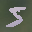

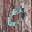

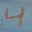

In [60]:
for n in range(3):
  image_path = sorted_img_paths[n]
  display.display(display.Image(image_path))
  print()

Combine MNIST and MNIST-M images, to get the channel stats for normalisation

In [61]:
all_domain_images = np.vstack((x_train, [(imageio.imread(i)[2:-2,2:-2,:]) for i in sorted_img_paths]))
channel_mean = all_domain_images.mean((0,1,2))

In [62]:
class BaselineModel(Model):
  def __init__(self):
    super(BaselineModel, self).__init__()
    
    self.normalise = lambda x: (tf.cast(x, tf.float64) - channel_mean) / 255.0
    self.conv1 = Conv2D(32, 5, activation='relu')
    self.conv2 = Conv2D(64, 5, activation='relu')
    self.maxpool = MaxPool2D(2)
    self.flatten = Flatten()
    
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')
    

  def call(self, x):
    x = self.normalise(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.d1(x)

    return self.d2(x)

model = BaselineModel()

In [63]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

Need a separate loss accumulator for each train/test dataset

In [64]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

m_test_loss = tf.keras.metrics.Mean(name='test_loss')
m_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Train and test ops

In [65]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [67]:
@tf.function
def test_step(mnist_images, labels, mnist_m_images, labels2):
  predictions = model(mnist_images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

  predictions = model(mnist_m_images)
  t_loss = loss_object(labels2, predictions)
    
  m_test_loss(t_loss)
  m_test_accuracy(labels2, predictions)

Train on MNIST, evaluate on MNIST and MNIST-M

In [68]:
EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_data, m_test_data in zip(test_ds,mnist_m_test_ds):
    test_step(test_data[0], test_data[1], m_test_data[0], m_test_data[1])
    
  template = 'Epoch {}, Train Accuracy: {}, Source Test Accuracy: {}, Target Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_accuracy.result()*100,
                         test_accuracy.result()*100,
                         m_test_accuracy.result()*100,))


Epoch 1, Train Accuracy: 96.97333526611328, Source Test Accuracy: 98.73999786376953, Target Test Accuracy: 61.861019134521484
Epoch 2, Train Accuracy: 97.93917083740234, Source Test Accuracy: 98.56500244140625, Target Test Accuracy: 59.24021530151367
Epoch 3, Train Accuracy: 98.38555145263672, Source Test Accuracy: 98.66333770751953, Target Test Accuracy: 58.70606994628906
Epoch 4, Train Accuracy: 98.64458465576172, Source Test Accuracy: 98.71749877929688, Target Test Accuracy: 59.197784423828125
Epoch 5, Train Accuracy: 98.82566833496094, Source Test Accuracy: 98.76399993896484, Target Test Accuracy: 59.52476119995117


## Domain confusion
Build separate components so that distinct sets of gradients are easily accessed:

- feature generator
- label classifier 
- domain classifier 

In [15]:
class FeatureGenerator(Model):
  def __init__(self):
    super(FeatureGenerator, self).__init__() 
    self.normalise = lambda x: (tf.cast(x, tf.float64) - channel_mean) / 255.0
    self.conv1 = Conv2D(32, 5, activation='relu')
    self.conv2 = Conv2D(64, 5, activation='relu')
    self.maxpool = MaxPool2D(2)
    self.flatten = Flatten()
    
  def call(self, x):
    x = self.normalise(x)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.maxpool(x)

    return self.flatten(x)

feature_generator = FeatureGenerator()

In [16]:
class LabelPredictor(Model):
  def __init__(self):
    super(LabelPredictor, self).__init__() 
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')
    

  def call(self, feats):  
    feats = self.d1(feats)

    return self.d2(feats)

label_predictor = LabelPredictor()

In [17]:
class DomainPredictor(Model):
  def __init__(self):
    super(DomainPredictor, self).__init__()   
    self.d3 = Dense(64, activation='relu')
    self.d4 = Dense(2, activation='softmax')

  def call(self, feats):
    feats = self.d3(feats)
    
    return self.d4(feats)

domain_predictor = DomainPredictor()

Make second training dataset of MNIST and MNIST-M images and their respective domains

In [18]:
x_train_domain_labels = np.ones([len(x_train)])
mnist_m_domain_labels = np.zeros([len(sorted_img_paths)])
all_domain_labels = np.hstack((x_train_domain_labels, mnist_m_domain_labels))

domain_train_ds = tf.data.Dataset.from_tensor_slices(
    (all_domain_images, tf.cast(all_domain_labels, tf.int8))).shuffle(60000).batch(32)

Separate optimizers to allow different learning rates

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

Discriminative losses

In [21]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

m_test_loss = tf.keras.metrics.Mean(name='m_test_loss')
m_test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='m_test_accuracy')

Confusion loss

In [22]:
conf_train_loss = tf.keras.metrics.Mean(name='c_train_loss')
conf_train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='c_train_accuracy')

## Adversarial loss

There are three sets of parameters to update, one for each component of the model. Label and domain classifiers are updated in the usual way. Parameters of the feature generator are updated using the standard gradient backpropagated from the label classifier, summed with the reverse of the gradient from the domain classifier; the feature generator learns to confound the domain classifier, resulting in domain invariant features which should be useful for general performance.


<img src="DANN_architecture.png" style="width: 600px;">


Image taken from: https://arxiv.org/pdf/1409.7495.pdf

In [25]:
@tf.function
def train_step(images, labels, images2, domains, alpha):
    
  """
  i. images = batch of source images
  ii. labels = corresponding labels
  iii. images2 = batch of source and target images
  iv. domains = corresponding domain labels
  v. alpha = weight attributed to the domain loss
  """
    
  ## Update the generator and the classifier
  with tf.GradientTape(persistent=True) as tape:
    features = feature_generator(images)
    l_predictions = label_predictor(features)
    features = feature_generator(images2)
    d_predictions = domain_predictor(features)
    label_loss = loss_object(labels, l_predictions)
    domain_loss = loss_object(domains, d_predictions)
    
  f_gradients_on_label_loss = tape.gradient(label_loss, feature_generator.trainable_variables)
  f_gradients_on_domain_loss = tape.gradient(domain_loss, feature_generator.trainable_variables)    
  f_gradients = [f_gradients_on_label_loss[i] - alpha*f_gradients_on_domain_loss[
      i] for i in range(len(f_gradients_on_domain_loss))]

    
  l_gradients = tape.gradient(label_loss, label_predictor.trainable_variables)

  f_optimizer.apply_gradients(zip(f_gradients+l_gradients, 
                                  feature_generator.trainable_variables+label_predictor.trainable_variables)) 
    
    
  ## Update the discriminator: Comment this bit to complete all updates in one step. Asynchronous updating 
  ## seems to work a bit better, with better accuracy and stability, but may take longer to train    
  with tf.GradientTape() as tape:
    features = feature_generator(images2)
    d_predictions = domain_predictor(features)
    domain_loss = loss_object(domains, d_predictions)
  #####
    
  d_gradients = tape.gradient(domain_loss, domain_predictor.trainable_variables)  
  d_gradients = [alpha*i for i in d_gradients]
  d_optimizer.apply_gradients(zip(d_gradients, domain_predictor.trainable_variables)) 
    
    
  train_loss(label_loss)
  train_accuracy(labels, l_predictions)
  conf_train_loss(domain_loss)
  conf_train_accuracy(domains, d_predictions)

In [26]:
@tf.function
def test_step(mnist_images, labels, mnist_m_images, labels2):
  features = feature_generator(mnist_images)
  predictions = label_predictor(features)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

  features = feature_generator(mnist_m_images)
  predictions = label_predictor(features)
  t_loss = loss_object(labels2, predictions)
    
  m_test_loss(t_loss)
  m_test_accuracy(labels2, predictions)

Train and evaluate. May need > 100 epochs for convergence

In [31]:
EPOCHS = 20
   
for epoch in range(EPOCHS):
  for domain_data, label_data in zip(domain_train_ds, train_ds):
    
    try:
      train_step(label_data[0], label_data[1], domain_data[0], domain_data[1], alpha=1)
     
    #End of the smaller dataset
    except ValueError: 
      pass
    
  for test_data, m_test_data in zip(test_ds,mnist_m_test_ds):
    test_step(test_data[0], test_data[1], m_test_data[0], m_test_data[1])
  
  template = 'Epoch {}, Train Accuracy: {}, Domain Accuracy: {}, Source Test Accuracy: {}, Target Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_accuracy.result()*100,
                         conf_train_accuracy.result()*100,
                         test_accuracy.result()*100,
                         m_test_accuracy.result()*100,))

Epoch 1, Train Accuracy: 97.89350128173828, Domain Accuracy: 76.03472900390625, Source Test Accuracy: 96.718017578125, Target Test Accuracy: 79.03201293945312
Epoch 2, Train Accuracy: 97.9066390991211, Domain Accuracy: 76.04347229003906, Source Test Accuracy: 96.72892761230469, Target Test Accuracy: 79.128662109375
Epoch 3, Train Accuracy: 97.92040252685547, Domain Accuracy: 76.05339050292969, Source Test Accuracy: 96.73681640625, Target Test Accuracy: 79.20795440673828
Epoch 4, Train Accuracy: 97.93437194824219, Domain Accuracy: 76.06088256835938, Source Test Accuracy: 96.74762725830078, Target Test Accuracy: 79.30022430419922
Epoch 5, Train Accuracy: 97.9473648071289, Domain Accuracy: 76.06851196289062, Source Test Accuracy: 96.75704193115234, Target Test Accuracy: 79.39383697509766
Epoch 6, Train Accuracy: 97.96015930175781, Domain Accuracy: 76.07662200927734, Source Test Accuracy: 96.76724243164062, Target Test Accuracy: 79.47990417480469
Epoch 7, Train Accuracy: 97.97249603271484,